
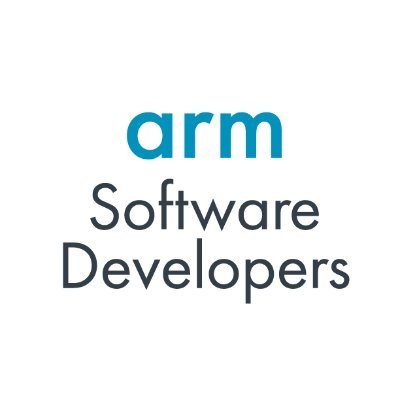</img>

# ML Audio Classifier Example for Pico

```
Copyright (c) 2021 Arm Limited and Contributors. All rights reserved.

SPDX-License-Identifier: Apache-2.0
```

Authors: [Sandeep Mistry](https://twitter.com/sandeepmistry), [Henri Woodcock](https://twitter.com/henriwoodcock) from the [Arm Software Developers team](https://twitter.com/armsoftwaredev)

## Introduction

This tutorial will guide you through how to train a TensorFlow based audio classification Machine Learning (ML) model to detect a fire alarm sound. We’ll show you how to use [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers) with Arm [CMSIS-NN](https://arm-software.github.io/CMSIS_5/NN/html/index.html) accelerated kernels to deploy the ML model to an [Arm Cortex-M0+](https://developer.arm.com/ip-products/processors/cortex-m/cortex-m0-plus) based microcontroller (MCU) board for local on-device ML interferencing. Arm’s [CMSIS-DSP](https://arm-software.github.io/CMSIS_5/DSP/html/index.html) library, which provides optimized Digital Signal Processing (DSP) function implementations for [Arm Cortex-M](https://developer.arm.com/ip-products/processors/cortex-m) processors, will also be used to extract features from the real-time audio data prior to inference.

While this guide focuses on detecting a fire alarm sound, it can be adapted for other sound classification tasks. You may also need to adapt the feature extraction stages and/or adjust ML model architecture for your use case.


## What you need to to get started

### Development Environment

 * [Google Chrome](https://www.google.com/intl/en_ca/chrome/)
 * [Google Colab](https://colab.research.google.com/notebooks/)
 * A [Google Account](https://www.google.com/account/about/)

### Hardware

You’ll need one of the following development boards that are based on [Raspberry Pi’s RP2040 MCU chip](https://www.raspberrypi.org/products/rp2040/) that was released early in 2021.


#### SparkFun RP2040 MicroMod and MicroMod ML Carrier

This is recommended for people who are new to electronics and microcontrollers. While it does cost a bit more than the option below, it is easier to assemble and does not require a soldering iron, knowing how to solder and how to wire up breadboards.

 * [SparkFun MicroMod RP2040 Processor](https://www.sparkfun.com/products/17720)
  * For the brains of the operation! Contains Raspberry Pi’s RP2040 MCU and 16MB of flash storage
 * [SparkFun MicroMod Machine Learning Carrier Board](https://www.sparkfun.com/products/16400)
Enables USB connectivity, and provides a built-in microphone, IMU and camera connector
 * A USB-C cable to connect the board to your computer
 * A Phillips screwdriver

#### Raspberry Pi Pico and PDM microphone board

This option is slightly lower in cost, however it requires a soldering iron and knowledge of how to wire a breadboard with electronic components.

 * [Raspberry Pi Pico](https://www.raspberrypi.org/products/raspberry-pi-pico/)
 * [Adafruit PDM MEMS Microphone Breakout](https://www.adafruit.com/product/3492)
 * Half size or full size breadboard
 * Jumper wires
 * A USB-B micro cable to connect the board to your computer
 * Soldering iron

#### More information

Both of the options above will allow you to collect real-time 16 kHz audio from a digital microphone and process the audio signal in real-time on the development board’s Arm Cortex-M0+ processor which operates at 125 MHz. The application running on the Arm Cortex-M0+ will have a Digital Signal Processing (DSP) stage to extract features from the audio signal, the extracted features will then be fed into a neural network to perform a classification task to determine if a fire alarm sound is present in the board’s environment.

### Hardware Setup

#### SparkFun MicroMod RP2040

For assembly, remove the screw on the carrier board, at an angle, slide in the MicroMod RP2040 Processor board into the socket and secure it in place with the screw. See the [MicroMod Machine Learning Carrier Board Hookup Guide](https://learn.sparkfun.com/tutorials/micromod-machine-learning-carrier-board-hookup-guide?_ga=2.90268890.1509654996.1628608170-268367655.1627493370#hardware-hookup) for more details.


#### Raspberry Pi Pico

Follow the instructions from the [Hardware Setup section of the "Create a USB Microphone with the Raspberry Pi Pico"](https://www.hackster.io/sandeep-mistry/create-a-usb-microphone-with-the-raspberry-pi-pico-cc9bd5#toc-hardware-setup-5) guide for assembly instructions.


## Install dependencies

### Python Libraries

Let's start by installing the Python library dependencies:

In [ ]:
!pip install librosa matplotlib pandas "tensorflow==2.8.*" "tensorflow-io==0.24.*" "tensorflow-model-optimization==0.7.2"

!pip install git+https://github.com/ARM-software/CMSIS_5.git@5.8.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/PythonWrapper

### Command line tools

Now let's install the command line tools we will need to build applications for the Raspberry Pi RP2040:

In [ ]:
import tensorflow as tf

tf.keras.utils.get_file('cmake-3.21.0-linux-x86_64.tar.gz',
                        'https://github.com/Kitware/CMake/releases/download/v3.21.0/cmake-3.21.0-linux-x86_64.tar.gz',
                        cache_dir='./',
                        cache_subdir='tools',
                        extract=True)

tf.keras.utils.get_file('gcc-arm-none-eabi-10-2020-q4-major-x86_64-linux.tar.bz2',
                        'https://developer.arm.com/-/media/Files/downloads/gnu-rm/10-2020q4/gcc-arm-none-eabi-10-2020-q4-major-x86_64-linux.tar.bz2',
                        cache_dir='./',
                        cache_subdir='tools',
                        extract=True)

In [ ]:
!apt-get install -y xxd

Now add the downloaded and extracted tools to the `PATH` environmental variable, so we can use them later on without specifying the full path to them:

In [ ]:
import os

os.environ['PATH'] = f"{os.getcwd()}/tools/cmake-3.21.0-linux-x86_64/bin:{os.environ['PATH']}"
os.environ['PATH'] = f"{os.getcwd()}/tools/gcc-arm-none-eabi-10-2020-q4-major/bin:{os.environ['PATH']}"

### Raspberry Pi Pico SDK

We can use `git` to get the `v1.2.0` of the [Raspberry Pi Pico SDK](https://github.com/raspberrypi/pico-sdk)

In [ ]:
%%shell
git clone --branch 1.2.0 https://github.com/raspberrypi/pico-sdk.git
cd pico-sdk
git submodule init
git submodule update

Set the `PICO_SDK_PATH` environment variable to specify the location of the `pico-sdk`

In [ ]:
os.environ['PICO_SDK_PATH'] = f"{os.getcwd()}/pico-sdk"

**You will need to change the code cell below** to select the board you will be using for the remainder of the tutorial.

By default the `PICO_BOARD` environment variable is set to `sparkfun_micromod` for the SparkFun RP2040 MicroMod. Set the value to `pico` if you are using a Raspberry Pi Pico board.

In [ ]:
# for SparkFun MicroMod
os.environ['PICO_BOARD'] = 'sparkfun_micromod'

# for Raspberry Pi Pico (uncomment next line)
# os.environ['PICO_BOARD'] = 'pico'

print(f"PICO_BOARD env. var. set to '{os.environ['PICO_BOARD']}'")

### Project Files

The source code for the inference application and Python utilities for Google Colab can also be cloned using `git`:

In [ ]:
%%shell
git clone --recurse-submodules https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico.git

For convenience we can create symbolic links for the project files that we've cloned to the root Google Colab folder:

In [ ]:
%%shell
ln -s ml-audio-classifier-example-for-pico/colab_utils colab_utils
ln -s ml-audio-classifier-example-for-pico/inference-app inference-app

## Baseline model

We will start by training a generic sound classifier model with TensorFlow using the [ESC-50: Dataset for Environmental Sound Classification](https://github.com/karolpiczak/ESC-50). This will allow us to create a more generic model that is trained on a broader dataset, and then use Transfer Learning later on to fine tune it for our specific audio classification task.

This model will be trained on the ESC-50 dataset, which contains 50 types of sounds; each sound category has 40 audio files that are 5 seconds each in length. Each audio file will be split into 1 second soundbites, and any soundbites that contain pure silence will be discarded.

### Prepare dataset

#### Download and extract

The ESC-50 dataset will be downloaded and extracted to the `datasets` folder using the [`tf.keras.utils.get_file(...)`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function.

In [ ]:
import tensorflow as tf

tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

#### Load dataset metadata

Now we will use the [pandas](https://pandas.pydata.org/) library to read the `datasets/ESC-50-master/meta/esc50.csv` file which contains the metadata for the audio files in the ESC-50 dataset:

In [ ]:
import pandas as pd

esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head()

Then add new column with the `fullpath` of the wave files:

In [ ]:
from os import path

base_data_path = './datasets/ESC-50-master/audio/'

df['fullpath'] = df['filename'].map(lambda x: path.join(base_data_path, x))

df.head()

#### Load wave file data

We can then define a new function named `load_wav` to load audio samples from a wave file using TensorFlow's [`tf.io.read_file(...)`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) and[`tf.audio.decode_wav(...)`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) API's. The [`tfio.audio.resample(...)`](https://www.tensorflow.org/io/api_docs/python/tfio/audio/resample) API will be used to resample the audio samples at the specified sampling rate.

[librosa](https://librosa.org/)'s [`load(...)`](https://librosa.org/doc/main/generated/librosa.load.html) API will be used as a fallback if TensorFlow is unable to decode the wave file.


In [ ]:
import tensorflow_io as tfio
import librosa

def load_wav(filename, desired_sample_rate, desired_channels):
  try:
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=desired_channels)
    wav = tf.squeeze(wav, axis=-1)
  except:
    # fallback to librosa if the wav file can be read with TF
    filename = tf.cast(filename, tf.string)
    wav, sample_rate = librosa.load(filename.numpy().decode('utf-8'), sr=None, mono=(desired_channels == 1))
  
  wav = tfio.audio.resample(wav, rate_in=tf.cast(sample_rate, dtype=tf.int64), rate_out=tf.cast(desired_sample_rate, dtype=tf.int64))

  return wav

Now let's load the first wave file, which is a sound of a dog barking, from the pandas `DataFrame`, and plot it overtime using `matplotlib`. The [`IPython.display.Audio(...)`](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.Audio) API can be used to playback the audio samples inside the notebook.




In [ ]:
import matplotlib.pyplot as plt
from IPython import display

sample_rate = 16000
channels = 1

test_wav_file_path = df['fullpath'][0]
test_wav_data = load_wav(test_wav_file_path, sample_rate, channels)

plt.plot(test_wav_data)
plt.show()

display.Audio(test_wav_data, rate=sample_rate)

If we zoom in and only plot samples `32000` to `48000`, we can get a closer plot of the audio samples in the wave file in the 2 to 3 second span:

In [ ]:
_ = plt.plot(test_wav_data[32000:48000])

We can then use the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) TensorFlow API to create a pipeline that loads all wave file data from the dataset.

In [ ]:
fullpaths = df['fullpath']
targets = df['target']
folds = df['fold']

fullpaths_ds = tf.data.Dataset.from_tensor_slices((fullpaths, targets, folds))
fullpaths_ds.element_spec

Map each `fullpath` value to wave file samples:

In [ ]:
def load_wav_for_map(fullpath, label, fold):
  wav = tf.py_function(load_wav, [fullpath, sample_rate, channels], tf.float32)

  return wav, label, fold

wav_ds = fullpaths_ds.map(load_wav_for_map)
wav_ds.element_spec

#### Split Wave file data

We would like to train the model on 1 secound soundbites, so we must split up the 5 seconds of audio per item in the ESC-50 dataset to slices of 16000 samples. We will also stride the original audio samples `4000` samples at a time, and filter out any sound chunks that contain pure silence.

In [ ]:
@tf.function
def split_wav(wav, width, stride):
  return tf.map_fn(fn=lambda t: wav[t * stride:t * stride + width], elems=tf.range((tf.shape(wav)[0] - width) // stride), fn_output_signature=tf.float32)

@tf.function
def wav_not_empty(wav):
  return tf.experimental.numpy.any(wav)

def split_wav_for_flat_map(wav, label, fold):
  wavs = split_wav(wav, width=16000, stride=4000)
  labels = tf.repeat(label, tf.shape(wavs)[0])
  folds = tf.repeat(fold, tf.shape(wavs)[0])

  return tf.data.Dataset.from_tensor_slices((wavs, labels, folds))

split_wav_ds = wav_ds.flat_map(split_wav_for_flat_map)
split_wav_ds = split_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

Let's plot the first 5 soundbites over time using `matplotlib`:

In [ ]:
for wav, _, _ in split_wav_ds.take(5):
  _ = plt.plot(wav)
  plt.show()

#### Create Spectrograms

Rather than passing in the time series data directly into our TensorFlow model, we will transform the audio data into an audio spectrogram representation. This will create a 2D representation of the audio signal’s frequency content over time.

The input audio signal we will use will have a sampling rate of 16kHz, this means one second of audio will contain 16,000 samples. Using TensorFlow’s [`tf.signal.stft(...)`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) function we can transform a 1 second audio signal into a 2D tensor representation. We will choose a frame length of 256 and a frame step of 128, so the output of this feature extraction stage will be a Tensor that has a shape of `(124, 129)`.


In [ ]:
@tf.function
def create_spectrogram(samples):
  return tf.abs(
      tf.signal.stft(samples, frame_length=256, frame_step=128)
  )

Let's take the same 2 - 3 second interval of the first dog barking wave file and create it's spectrogram representation:

In [ ]:
spectrogram = create_spectrogram(test_wav_data[32000:48000])

spectrogram.shape

We can then create `plot_spectrogram` function to plot the spectrogram representation using `matplotlib`:

In [ ]:
import numpy as np

def plot_spectrogram(spectrogram, vmax=None):
  transposed_spectrogram = tf.transpose(spectrogram)

  fig = plt.figure(figsize=(8,6))
  height = transposed_spectrogram.shape[0]
  X = np.arange(transposed_spectrogram.shape[1])
  Y = np.arange(height * int(sample_rate / 256), step=int(sample_rate / 256))

  im = plt.pcolormesh(X, Y, tf.transpose(spectrogram), vmax=vmax)

  fig.colorbar(im)
  plt.show()


plot_spectrogram(spectrogram)

Then we can map each split wave item to a spectrogram:

In [ ]:
def create_spectrogram_for_map(samples, label, fold):
  return create_spectrogram(samples), label, fold

spectrograms_ds = split_wav_ds.map(create_spectrogram_for_map)
spectrograms_ds.element_spec

Let's plot the first 5 spectrograms in the dataset:

In [ ]:
for s, _, _ in spectrograms_ds.take(5):
  plot_spectrogram(s)

### Split Dataset

Before we start training the ML classifier model, we must split the dataset up in three parts: training, validation, and test.

We will use the same technique in TensorFlow's [Transfer learning with YAMNet for environmental sound classification](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data) guide, and use the `fold` column of the ESC-50 dataset to determine the split.

Before splitting the dataset, let's set a random seed for reproducibility:

In [ ]:
import numpy as np
import tensorflow as tf

# Set seed for experiment reproducibility
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Entries with a `fold` value of less than 4 will used for training, the ones with a `value` will be used for validation, and finally the remaining items with be used for testing.

The `fold` column will be removed as it is no longer needed, and the dimensions of the spectrogram shape will be expanded from `(124, 129)` to `(124, 129, 1)`. The training items will also be shuffled.

In [ ]:
cached_ds = spectrograms_ds.cache()

train_ds = cached_ds.filter(lambda spectrogram, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda spectrogram, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda spectrogram, label, fold: fold > 4)

# remove the folds column as it's no longer needed
remove_fold_column = lambda spectrogram, label, fold: (tf.expand_dims(spectrogram, axis=-1), label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000, seed=random_seed).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

### Train Model

Now that we have the features extracted from the audio signal, we can create a model using TensorFlow’s Keras  API. The model will consist of 8 layers:

 1. An input layer.
 1. A preprocessing layer, that will resize the input tensor from 124x129x1 to 32x32x1.
 1. A normalization layer, that will scale the input values between -1 and 1
 1. A 2D convolution layer with: 8 filters, a kernel size of 8x8, and stride of 2x2, and ReLU activation function.
 1. A 2D max pooling layer with size of 2x2
 1. A flatten layer to flatten the 2D data to 1D
 1. A dropout layer, that will help reduce overfitting during training
 1. A dense layer with 50 outputs and a softmax activation function, which outputs the likelihood of the sound category (between 0 and 1).


Before we build the model using [Tensflow's Keras API's](https://www.tensorflow.org/api_docs/python/tf/keras), we will create normalization layer and feed in all the spectrogram dataset items.

In [ ]:
for spectrogram, _, _ in cached_ds.take(1):
    input_shape = tf.expand_dims(spectrogram, axis=-1).shape
    print('Input shape:', input_shape)
  
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(cached_ds.map(lambda x, y, z: tf.reshape(x, input_shape)))

Define a sequential 8 layer model as described above:

In [ ]:
baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.experimental.preprocessing.Resizing(32, 32, interpolation="nearest"), 
  norm_layer,
  tf.keras.layers.Conv2D(8, kernel_size=(8,8), strides=(2, 2), activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(50, activation='softmax')
])

baseline_model.summary()

Compile the model with `accuracy` metrics, an Adam optimizer and a sparse categorical crossentropy loss function. As well as define early stopping and dynamic learning rate scheduler callbacks for training.

In [ ]:
METRICS = [
      "accuracy",
]

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=25), 
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

Train the model:

In [ ]:
EPOCHS = 250
history = baseline_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks,
)

Evaluate the loss and accuracy of the test dataset:

In [ ]:
baseline_model.evaluate(test_ds)

The baseline model has a relatively low accuracy ~24%, however in the next steps we will use it as a starting point to fine tune a more accurate model for our use case.

Save the model:

In [ ]:
baseline_model.save("baseline_model")

Create a zip file of the saved model, for download purposes:

In [ ]:
!zip -r baseline_model.zip baseline_model

## Transfer Learning

Now we will use Transfer Learning and change the classification head of the model to train a binary classification model for fire alarm sounds.

Transfer Learning is the process of retraining a model that has been developed for a task to complete a new similar task. The idea is that the model has learned transferable "skills" and the weights and biases can be used in other models as a starting point.

Transfer learning is very common in computer vision. Big data companies spend weeks training models on ImageNet, this is not possible for most people and so people reuse the models built in these research companies to complete their own tasks. A model designed to recognise 1000 different objects in a image can be adapted to recognise other or similar objects.

As humans we use transfer learning too. The skills you developed to learn to walk could also be used to learn to run later on.

In a neural network, the first few layers of a model start to perform a "feature extraction" such as finding shapes, edges and colours. The layers later on are used as classifiers; they take the extracted features and classify them.

You can find more information and visualizations about this here https://yosinski.com/deepvis.

Because of this, we can assume the first few layers have learned quite general feature extraction techniques that can be applied to all similar tasks and so we can freeze all these layers. The classifier layer will need to be trained based on the new classes.

To do this, we break the process into two steps:
Freeze the "backbone" of the model and train the head with a fairly high learning rate. We slowly reduce the learning rate.
Unfreeze the "backbone" and fine-tune the model with a low learning rate.


### Dataset

We have collected 10 fire alarm clips from [freesound.org](https://freesound.org/) and [BigSoundBank.com](https://bigsoundbank.com/).  Background noise clips from the [SpeechCommands](https://www.tensorflow.org/datasets/catalog/speech_commands) dataset, will be used for non-fire alarm sounds. This dataset is small and represents the sort of data you might expect to see in the real world. Data augmentation techniques will be used to supplement the training data we’ve collected.

### Download datasets

We've created an archive with the following wave files for you:

 * https://freesound.org/people/rayprice/sounds/155006/ ([CC BY 3.0 license](https://creativecommons.org/licenses/by/3.0/))

 * https://freesound.org/people/deleted_user_2104797/sounds/164686/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

 * https://freesound.org/people/AdamWeeden/sounds/255180/ ([CC BY 3.0 license](https://creativecommons.org/licenses/by/3.0/))

* https://freesound.org/people/MoonlightShadow/sounds/325367/([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://freesound.org/people/SpliceSound/sounds/369847/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://freesound.org/people/SpliceSound/sounds/369848/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://bigsoundbank.com/detail-0800-smoke-detector-alarm.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))

* https://bigsoundbank.com/detail-1151-smoke-detector-alarm-2.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))

* https://bigsoundbank.com/detail-1153-smoke-detector-alarm-3.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))


In [ ]:
tf.keras.utils.get_file('fire_alarms.tar.gz',
                        'https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/archive/refs/heads/fire_alarms.tar.gz',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [ ]:
# Since we only need the files in the _background_noise_ folder of the dataset
# use the curl command to download the archive file and then manually extract
# using the tar command, instead of using tf.keras.utils.get_file(...) 
# in Python

!mkdir -p datasets/speech_commands
!curl -L -o datasets/speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar --wildcards --directory datasets/speech_commands -xzvf datasets/speech_commands_v0.02.tar.gz './_background_noise_/*'

### Load dataset

Instead of using a pandas DataFrame to load the dataset, we will load the fire alarm files and background noise files separately. The `label` and `fold` values will be mapped manually.

In [ ]:
fire_alarm_files_ds = tf.data.Dataset.list_files("datasets/ml-audio-classifier-example-for-pico-fire_alarms/*.wav", shuffle=False)
fire_alarm_files_ds = fire_alarm_files_ds.map(lambda x: (x, 1, -1))

In [ ]:
background_noise_files_ds = tf.data.Dataset.list_files("datasets/speech_commands/_background_noise_/*.wav", shuffle=False)
background_noise_files_ds = background_noise_files_ds.map(lambda x: (x, 0, -1))

In [ ]:
fire_alarm_wav_ds = fire_alarm_files_ds.map(load_wav_for_map)
fire_alarm_wav_ds = fire_alarm_wav_ds.cache()

background_noise_wav_ds = background_noise_files_ds.map(load_wav_for_map)
background_noise_wav_ds = background_noise_wav_ds.cache()

Let's plot and listen to the first fire alarm file:

In [ ]:
for wav_data, _, _ in fire_alarm_wav_ds.take(1):
  plt.plot(wav_data)
  plt.ylim([-1, 1])
  plt.show()

  display.display(display.Audio(wav_data, rate=sample_rate))

Then do the same for the first background noise file:

In [ ]:
for wav_data, _, _ in background_noise_wav_ds.take(1):
  plt.plot(wav_data)
  plt.ylim([-1, 1])
  plt.show()

  display.display(display.Audio(wav_data, rate=sample_rate))

Then split the audio samples into 1 second soundbites:

In [ ]:
split_fire_alarm_wav_ds = fire_alarm_wav_ds.flat_map(split_wav_for_flat_map)
split_fire_alarm_wav_ds = split_fire_alarm_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

split_background_noise_wav_ds = background_noise_wav_ds.flat_map(split_wav_for_flat_map)
split_background_noise_wav_ds = split_background_noise_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

TensorFlow Lite for Microcontroller (TFLu) provides a subset of TensorFlow operations, so we are unable to use the `tf.signal.sft(...)` API we’ve used for feature extraction of the baseline model on our MCU. However, we can leverage Arm’s CMSIS-DSP library to generate spectrograms on the MCU. CMSIS-DSP contains support for both floating-point and fixed-point DSP operations which are optimized for Arm Cortex-M processors, including the Arm Cortex-M0+ that we will be deploying the ML model to. The Arm Cortex-M0+ does not contain a floating-point unit (FPU) so it would be better to leverage a 16-bit fixed-point DSP based feature extraction pipeline on the board.

We can leverage CMSIS-DSP’s Python Wrapper in the notebook to perform the same operations on our training pipeline using 16-bit fixed-point math. At a high level we can replicate the TensorFlow SFT API with the following CMSIS-DSP based operations:

 1. Manually creating a Hanning Window of length 256 using the Hanning Window formula along with CMSIS-DSP’s `arm_cos_f32` API.
 1. Creating a CMSIS-DSP `arm_rfft_instance_q15` instance and initializing it using CMSIS-DSP’s `arm_rfft_init_q15` API. 
 1. Looping through the audio data 256 samples at a time, with a stride of 128 (this matches the parameters we’ve passed into the TF sft API)
  1. Multiplying the 256 samples by the Hanning Window, using CMSIS-DSP’s `arm_mult_q15` API
  1. Calculating the FFT of the output of the previous step, using CMSIS-DSP’s `arm_rfft_q15` API
  1. Calculating the magnitude of the previous step, using CMSIS-DSP’s `arm_cmplx_mag_q15` API
 1. Each audio soundbites’s FFT magnitude represents the one column of the spectrogram.
 1. Since our baseline model expects a floating-point input, instead of the 16-bit quantized value we were using, the CMSIS-DSP `arm_q15_to_float` API can be used to convert the spectrogram data from a 16-bit fixed-point value to a floating-point value for training.

For an in-depth description of how to create audio spectrograms using fixed-point operations with CMSIS-DSP, please see the [Towards Data Science “Fixed-point DSP for Data Scientists” guide](https://towardsdatascience.com/fixed-point-dsp-for-data-scientists-d773a4271f7f).



In [ ]:
import cmsisdsp
from numpy import pi as PI

window_size = 256
step_size = 128

hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
  hanning_window_f32[i] = 0.5 * (1 - cmsisdsp.arm_cos_f32(2 * PI * i / window_size ))

hanning_window_q15 = cmsisdsp.arm_float_to_q15(hanning_window_f32)

rfftq15 = cmsisdsp.arm_rfft_instance_q15()
status = cmsisdsp.arm_rfft_init_q15(rfftq15, window_size, 0, 1)

def get_arm_spectrogram(waveform):
  
  num_frames = int(1 + (len(waveform) - window_size) // step_size)
  fft_size = int(window_size // 2 + 1)

  # Convert the audio to q15
  waveform_q15 = cmsisdsp.arm_float_to_q15(waveform)

  # Create empty spectrogram array
  spectrogram_q15 = np.empty((num_frames, fft_size), dtype = np.int16)

  start_index = 0

  for index in range(num_frames):
    # Take the window from the waveform.
    window = waveform_q15[start_index:start_index + window_size]

    # Apply the Hanning Window.
    window = cmsisdsp.arm_mult_q15(window, hanning_window_q15)

    # Calculate the FFT, shift by 7 according to docs
    window = cmsisdsp.arm_rfft_q15(rfftq15, window)

    # Take the absolute value of the FFT and add to the Spectrogram.
    spectrogram_q15[index] = cmsisdsp.arm_cmplx_mag_q15(window)[:fft_size]

    # Increase the start index of the window by the overlap amount.
    start_index += step_size

  # Convert to numpy output ready for keras
  return cmsisdsp.arm_q15_to_float(spectrogram_q15).reshape(num_frames,fft_size) * 512

Let's create a spectrogram representation for all of the fire alarm soundbites, and plot the first spectrogram.

In [ ]:
@tf.function
def create_arm_spectrogram_for_map(wav, label, fold):
  spectrogram = tf.py_function(get_arm_spectrogram, [wav], tf.float32)

  return spectrogram, label, fold

fire_alarm_spectrograms_ds = split_fire_alarm_wav_ds.map(create_arm_spectrogram_for_map)
fire_alarm_spectrograms_ds = fire_alarm_spectrograms_ds.cache()

for spectrogram, _, _ in fire_alarm_spectrograms_ds.take(1):
  plot_spectrogram(spectrogram)


The do the same for the background noise soundbites:

In [ ]:
background_noise_spectrograms_ds = split_background_noise_wav_ds.map(create_arm_spectrogram_for_map)
background_noise_spectrograms_ds = background_noise_spectrograms_ds.cache()

for spectrogram, _, _ in background_noise_spectrograms_ds.take(1):
  plot_spectrogram(spectrogram)

Now let's calculate the lengths of each dataset to see how balanced they are:

In [ ]:
def calculate_ds_len(ds):
  count = 0
  for _, _, _ in ds:
    count += 1
  
  return count

num_fire_alarm_spectrograms = calculate_ds_len(fire_alarm_spectrograms_ds)
num_background_noise_spectrograms = calculate_ds_len(background_noise_spectrograms_ds)

print(f"num_fire_alarm_spectrograms = {num_fire_alarm_spectrograms}")
print(f"num_background_noise_spectrograms = {num_background_noise_spectrograms}")

We can see there a more background noise samples than fire alarm samples. In the next section we will use data augmentation to balance this.

### Data Augmentation

Data augmentation is a set of techniques used to increase the size of a dataset. This is done by slightly modifying samples from the dataset or by creating synthetic data. In this situation we are using audio and we will create a few functions to augment the different samples. We will use three techniques:

 * adding white noise to the audio samples
 * adding random silence to the audio
 * mixing two audio samples together

As well as increasing the size of the dataset, data augmentation also helps to reduce overfitting by training the model on different (not perfect) data samples. For example, on a microcontroller you are unlikely to have perfect high quality audio, and so a technique like adding white noise can help the model work in situations where your microphone might every so often have noise in there.

First let's plot the time representation of the first fire alarm soundbite over time along with it's spectrogram representation, so we can compare against the augmented versions.


In [ ]:
for wav, _, _ in split_fire_alarm_wav_ds.take(1):
  test_fire_alarm_wav = wav

plt.plot(test_fire_alarm_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_wav, rate=sample_rate))

#### White Noise

TensorFlow's [`tf.random.uniform(...)`](https://www.tensorflow.org/api_docs/python/tf/random/uniform) API can be used generate a Tensor of equal shape to the original audio. This Tensor can then be multiplied by a random scalar, and then added to the original audio samples. The [`tf.clip_by_value(...)`](https://www.tensorflow.org/api_docs/python/tf/clip_by_value) API will also be used to ensure the audio remains in the range of -1.0 to 1.0.

In [ ]:
def add_white_noise(audio):
  #generate noise and the scalar multiplier
  noise = tf.random.uniform(shape=tf.shape(audio), minval=-1, maxval=1)
  noise_scalar = tf.random.uniform(shape=[1], minval=0, maxval=0.2)

  # add them to the original audio
  audio_with_noise = audio + (noise * noise_scalar)
  
  # final clip the values to ensure they are still between -1 and 1
  audio_with_noise = tf.clip_by_value(audio_with_noise, clip_value_min=-1, clip_value_max=1)
  
  return audio_with_noise

Let's apply the white noise to the fire alarm sound and then plot it to compare. We can also listen to the difference.

In [ ]:
test_fire_alarm_with_white_noise_wav = add_white_noise(test_fire_alarm_wav)

plt.plot(test_fire_alarm_with_white_noise_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_white_noise_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_white_noise_wav, rate=sample_rate))

#### Random Silence

TensorFlow's [`tf.random.categorical(...)`](https://www.tensorflow.org/api_docs/python/tf/random/categorical) API can be used generate a Tensor of equal shape to the original audio containing mask of `True` or `False`. This mask can then be casted to a float type of 1.0 or 0.0, so that it can be multiplied by the original audio single to create random periods of silence.

In [ ]:
def add_random_silence(audio):
  audio_mask = tf.random.categorical(tf.math.log([[0.2, 0.8]]), num_samples=tf.shape(audio)[0])
  audio_mask = tf.cast(audio_mask, dtype=tf.float32)
  audio_mask = tf.squeeze(audio_mask, axis=0)

  # multiply the audio input by the mask
  augmented_audio = audio * audio_mask
  
  return augmented_audio

Let's apply the random silence to the fire alarm sound and then plot it to compare. We can also listen to the difference.

In [ ]:
test_fire_alarm_with_random_silence_wav = add_random_silence(test_fire_alarm_wav)

plt.plot(test_fire_alarm_with_random_silence_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_random_silence_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_random_silence_wav, rate=sample_rate))

#### Audio Mixups

We can combine a fire alarm soundbite with a background noise soundbite to create a mixed up version of the two.

Let's select the first background noise soundbite do see how this can be done.

In [ ]:
for wav, _, _ in split_background_noise_wav_ds.take(1):
  test_background_noise_wav = wav

plt.plot(test_background_noise_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_background_noise_wav))

display.display(display.Audio(test_background_noise_wav, rate=sample_rate))

We will multiply the background noise soundbite with a random scalar before adding it to the original fire alarm soundbite. Then ensure the mixed up value is between the range of -1.0 and 1.0.

In [ ]:
def add_audio_mixup(audio, mixup_audio):
  # randomly generate a scalar
  noise_scalar = tf.random.uniform(shape=[1], minval=0, maxval=1)

  # add the background noise to the audio
  augmented_audio = audio + (mixup_audio * noise_scalar)
  
  #final clip the values so they are stil between -1 and 1
  augmented_audio = tf.clip_by_value(augmented_audio, clip_value_min=-1, clip_value_max=1)
  
  return augmented_audio

Let's apply the audio mixup to the fire alarm sound and then plot it to compare. We can also listen to the difference.

In [ ]:
test_fire_alarm_with_mixup_wav = add_audio_mixup(test_fire_alarm_wav, test_background_noise_wav)

plt.plot(test_fire_alarm_with_mixup_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_mixup_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_mixup_wav, rate=sample_rate))

### Create Augmented Dataset

We can now combine all three augmententation techniques to balance our dataset.

First let's calculate how many augmented files we need to generate:

In [ ]:
num_augmented_fire_alarm_spectrograms = num_background_noise_spectrograms - num_fire_alarm_spectrograms

print(f'num_augmented_fire_alarm_spectrograms = {num_augmented_fire_alarm_spectrograms}')

Then we can divide by 3, to calculate how many augmented soundbites per technique to generate:

In [ ]:
num_white_noise_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3
num_random_silence_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3
num_audio_mixup_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3

print(f'num_white_noise_fire_alarm_spectrograms = {num_white_noise_fire_alarm_spectrograms}')
print(f'num_random_silence_fire_alarm_spectrograms = {num_random_silence_fire_alarm_spectrograms}')
print(f'num_audio_mixup_fire_alarm_spectrograms = {num_audio_mixup_fire_alarm_spectrograms}')

Select and shuffle the number of soundbites required:

In [ ]:
split_fire_alarm_wav_ds = split_fire_alarm_wav_ds.cache()
preaugmented_split_fire_alarm_wav = split_fire_alarm_wav_ds.shuffle(num_augmented_fire_alarm_spectrograms, seed=random_seed).take(num_augmented_fire_alarm_spectrograms)

Create the white noise augmented soundbites:

In [ ]:
def add_white_noise_for_map(wav, label, fold):
  return add_white_noise(wav), label, fold

white_noise_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.take(num_white_noise_fire_alarm_spectrograms)
white_noise_fire_alarm_wav_ds = white_noise_fire_alarm_wav_ds.map(add_white_noise_for_map)

Create the random noise augmented soundbites:

In [ ]:
def add_random_silence_for_map(wav, label, fold):
  return add_random_silence(wav), label, fold

random_silence_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.skip(num_white_noise_fire_alarm_spectrograms)
random_silence_fire_alarm_wav_ds = random_silence_fire_alarm_wav_ds.take(num_random_silence_fire_alarm_spectrograms)
random_silence_fire_alarm_wav_ds = random_silence_fire_alarm_wav_ds.map(add_random_silence_for_map)

Create the audio mixup augmented soundbites:

In [ ]:
audio_mixup_background_noise_ds = split_background_noise_wav_ds.shuffle(num_audio_mixup_fire_alarm_spectrograms).take(num_audio_mixup_fire_alarm_spectrograms)
audio_mixup_background_noise_iter = iter(audio_mixup_background_noise_ds.map(lambda x, y, z: x))

def add_audio_mixup_for_map(wav, label, fold):
  return add_audio_mixup(wav, next(audio_mixup_background_noise_iter)), label, fold

audio_mixup_split_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.skip(num_white_noise_fire_alarm_spectrograms + num_random_silence_fire_alarm_spectrograms)
audio_mixup_split_fire_alarm_wav_ds = audio_mixup_split_fire_alarm_wav_ds.take(num_audio_mixup_fire_alarm_spectrograms)
audio_mixup_split_fire_alarm_wav_ds = audio_mixup_split_fire_alarm_wav_ds.map(add_audio_mixup_for_map)

Combine all the augmented soundbites together and map them to their spectrogram representations:

In [ ]:
augment_split_fire_alarm_wav_ds = tf.data.Dataset.concatenate(white_noise_fire_alarm_wav_ds, random_silence_fire_alarm_wav_ds)
augment_split_fire_alarm_wav_ds = tf.data.Dataset.concatenate(augment_split_fire_alarm_wav_ds, audio_mixup_split_fire_alarm_wav_ds)

augment_fire_alarm_spectrograms_ds = augment_split_fire_alarm_wav_ds.map(create_arm_spectrogram_for_map)

### Split Dataset

Now combine the spectrogram datasets, and split them into training, validation, and test sets. Instead of using the `fold` value to split them, we will shuffle all the items, and then split by percentage.

In [ ]:
full_ds = tf.data.Dataset.concatenate(fire_alarm_spectrograms_ds, background_noise_spectrograms_ds)
full_ds = tf.data.Dataset.concatenate(full_ds, augment_fire_alarm_spectrograms_ds)
full_ds = full_ds.cache()

full_ds_size = calculate_ds_len(full_ds)

print(f'full_ds_size = {full_ds_size}')

full_ds = full_ds.shuffle(full_ds_size)

In [ ]:
train_ds_size = int(0.60 * full_ds_size)
val_ds_size = int(0.20 * full_ds_size)
test_ds_size = int(0.20 * full_ds_size)

train_ds = full_ds.take(train_ds_size)

remaining_ds = full_ds.skip(train_ds_size) 
val_ds = remaining_ds.take(val_ds_size)
test_ds = remaining_ds.skip(val_ds_size)

# remove the folds column as it's no longer needed
remove_fold_column = lambda spectrogram, label, fold: (tf.expand_dims(spectrogram, axis=-1), label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

### Replace Baseline Model Classification Head and Train Model

The model we previously trained on the ESC-50 dataset, predicted the presence of 50 sound types, and which resulted in the final dense layer of the model having 50 outputs. The new model we would like to create is a binary classifier, and needs to have a single output value.

We will load the baseline model, and swap out the final dense layer to match our needs:


In [ ]:
# we need a new head with one neuron.
model_body = tf.keras.Model(inputs=baseline_model.input, outputs=baseline_model.layers[-2].output)

classifier_head = tf.keras.layers.Dense(1, activation="sigmoid")(model_body.output)

fine_tune_model = tf.keras.Model(model_body.input, classifier_head)

fine_tune_model.summary()

To freeze a layer in TensorFlow we can set `layer.trainable = False`. Let's loop through all the layers and do this:

In [ ]:
for layer in fine_tune_model.layers:
  layer.trainable = False

and now unfreeze the last layer (the head):

In [ ]:
fine_tune_model.layers[-1].trainable = True

Then we can `compile` the model, this time with using a binary crossentropy loss function as this model contains a single output.

In [ ]:
METRICS = [
      "accuracy",
]

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5), 
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

Kick off training:

In [ ]:
EPOCHS = 25

history_1 = fine_tune_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks,
)

Now unfreeze all the layers, and train for a few more epochs:

In [ ]:
for layer in fine_tune_model.layers:
  layer.trainable = True

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  return lr * tf.math.exp(-0.1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5), 
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

In [ ]:
EPOCHS = 10

history_2 = fine_tune_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks,
)

In [ ]:
fine_tune_model.save("fine_tuned_model")

## Training with your own audio (optional)



We now have an ML model which can classify the presence of fire alarm sound. However this model was trained on publicly available sound recordings which might not match the sound characteristics of the hardware microphone we will use for inferencing.

The Raspberry Pi RP2040 MCU has a native USB feature that allows it to act like a USB microphone. We can flash an application to the board to enable it to act like a USB microphone to our PC. Then we can extend Google Colab’s capabilities with the [Web Audio API](https://developer.mozilla.org/en-US/docs/Web/API/Web_Audio_API) on a modern Web browser like Google Chrome to collect live data samples all from within Google Colab!

**If you don't have a fire alarm handy to record from, you can skip to the [next section](#scrollTo=Model_Optimization).**


### Record your own audio

#### Software Setup

Now we can use the USB microphone example from the [Microphone Library for Pico](https://github.com/ArmDeveloperEcosystem/microphone-library-for-pico). The example application can be compiled using `cmake` and `make`. Then we can flash the example application to the board over USB by putting the board into “boot ROM mode” which will allow us to upload an application to the board.

Let's use `git` to clone the library source code and accompanying examples:


In [ ]:
%%shell
git clone https://github.com/ArmDeveloperEcosystem/microphone-library-for-pico.git

Now let's change to the libraries directory folder, and create a `build` folder to run `cmake` on:

In [ ]:
%%shell
cd microphone-library-for-pico
mkdir -p build
cd build
cmake .. -DPICO_BOARD=${PICO_BOARD}

Then we can run `make` to compile the example:

In [ ]:
%%shell
cd microphone-library-for-pico/build

make -j usb_microphone

#### Flashing the board

If you are using a [WebUSB API](https://wicg.github.io/webusb/) enabled browser like Google Chrome, you can directly flash the image onto the board from within Google Collab! (Otherwise, you can manually download the .uf2 file to your computer and then drag it onto the USB disk for the RP2040 board.)

**Note for Windows**: If you are using Windows you must install WinUSB drivers in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/windows.md).

**Note for Linux**: If you are using Linux you must configure udev in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/linux.md).

First you must place the board in USB Boot ROM mode, as follows:

 * SparkFun MicroMod
  * Plug the USB-C cable into the board and your PC to power the board
  * While holding down the BOOT button on the board, tap the RESET button
 * Raspberry Pi Pico
  * Plug the USB Micro cable into your PC, but do NOT plug in the Pico side.
  * While holding down the white BOOTSEL button, plug in the micro USB cable to the Pico







Run the code cell below and then click the "Flash" button to upload the USB microphone example application to the board over USB.

In [ ]:
from colab_utils.pico import flash_pico

flash_pico('microphone-library-for-pico/build/examples/usb_microphone/usb_microphone.bin')

Now you can record audio by running the cells below, select the "MicNode" item from the drop down, and then click the "Starting Recording" button to start capturing audio. You must click the "Stop Recording" button to stop recording.

Record the your own fire alarm sounds:

In [ ]:
from colab_utils.audio import record_wav_file

os.makedirs('datasets/custom/fire_alarm', exist_ok=True)

record_wav_file('datasets/custom/fire_alarm')

Record the your own background noise sounds:

In [ ]:
os.makedirs('datasets/custom/background_noise', exist_ok=True)

record_wav_file('datasets/custom/background_noise')

We can zip up the recorded wave files to download and use again:

In [ ]:
!zip -r custom.zip datasets/custom

### Load dataset

We can load and transform the custom recorded dataset using the same pipeline we used before.

In [ ]:
custom_fire_alarm_ds = tf.data.Dataset.list_files("datasets/custom/fire_alarm/*.wav", shuffle=False)
custom_fire_alarm_ds = custom_fire_alarm_ds.map(lambda x: (x, 1, -1))
custom_fire_alarm_ds = custom_fire_alarm_ds.map(load_wav_for_map)
custom_fire_alarm_ds = custom_fire_alarm_ds.flat_map(split_wav_for_flat_map)
custom_fire_alarm_ds = custom_fire_alarm_ds.map(create_arm_spectrogram_for_map)

custom_background_noise_ds = tf.data.Dataset.list_files("datasets/custom/background_noise/*.wav", shuffle=False)
custom_background_noise_ds = custom_background_noise_ds.map(lambda x: (x, 0, -1))
custom_background_noise_ds = custom_background_noise_ds.map(load_wav_for_map)
custom_background_noise_ds = custom_background_noise_ds.flat_map(split_wav_for_flat_map)
custom_background_noise_ds = custom_background_noise_ds.map(create_arm_spectrogram_for_map)

custom_ds = tf.data.Dataset.concatenate(custom_fire_alarm_ds, custom_background_noise_ds)
custom_ds = custom_ds.map(lambda x, y, z: (tf.expand_dims(x, axis=-1), y, z))
custom_ds_len = calculate_ds_len(custom_ds)

print(f'{custom_ds_len}')

custom_ds = custom_ds.map(lambda x, y,z: (x, y))

custom_ds = custom_ds.shuffle(custom_ds_len).cache()

Evaluate dataset performance before training:

In [ ]:
fine_tune_model.evaluate(custom_ds.batch(1))

### Fine tune model

In [ ]:
EPOCHS = 25

for layer in fine_tune_model.layers:
  layer.trainable = False

fine_tune_model.layers[-1].trainable = True

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

history3 = fine_tune_model.fit(
    custom_ds.take(int(custom_ds_len * 0.8)).batch(1), 
    validation_data=custom_ds.skip(int(custom_ds_len * 0.8)).batch(1),  
    epochs=EPOCHS,
    # callbacks=callbacks,
)

In [ ]:
fine_tune_model.evaluate(custom_ds.batch(1))

In [ ]:
fine_tune_model.save('fine_tuned_model')

## Model Optimization

To optimize the model to run on the Arm Cortex-M0+ processor, we will use a process called model quantization. Model quantization converts the model’s weights and biases from 32-bit floating-point values to 8-bit values. The [pico-tflmicro](https://github.com/raspberrypi/pico-tflmicro) library, which is a port of TFLu for the RP2040’s Pico SDK contains Arm’s CMSIS-NN library, which supports optimized kernel operations for quantized 8-bit weights on Arm Cortex-M processors.



### Quantization Aware Training

We can use [TensorFlow’s Quantization Aware Training (QAT)](https://www.tensorflow.org/model_optimization/guide/quantization/training) feature to easily convert the floating-point model to quantized.

In [ ]:
final_model = tf.keras.models.load_model("fine_tuned_model")

In [ ]:
import tensorflow_model_optimization as tfmot

def apply_qat_to_dense_and_cnn(layer):
  if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

annotated_model = tf.keras.models.clone_model(
    fine_tune_model,
    clone_function=apply_qat_to_dense_and_cnn,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

In [ ]:
quant_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

EPOCHS=1
quant_aware_history = quant_aware_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS
)

### Saving model in TFLite format

We will now use the [tf.lite.TFLiteConverter.from_keras_model(...)](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_keras_model) API to convert the quantized Keras model to TF Lite format, and then save it to disk as a `.tflite` file.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]
    
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

with open("tflite_model.tflite", "wb") as f:
  f.write(tflite_model_quant)

### Test TF Lite model

Since TensorFlow also supports loading TF Lite models using [`tensorflow.lite`](https://www.tensorflow.org/api_docs/python/tf/lite), we can also verify the functionality of the quantized model and compare its accuracy with the regular unquantized model inside the notebook.

In [ ]:
import tensorflow.lite as tflite

# Load the interpreter and allocate tensors
interpreter = tflite.Interpreter("tflite_model.tflite")
interpreter.allocate_tensors()

# Load input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Set quantization values
input_scale, input_zero_point = input_details["quantization"]
output_scale, output_zero_point = output_details["quantization"]

In [ ]:
# Calculate the number of correct predictions
correct = 0
test_ds_len = 0

# Loop through entire test set
for x, y in test_ds.unbatch():
  # original shape is [124, 129, 1] expand to [1, 124, 129, 1]
  x = tf.expand_dims(x, 0).numpy()
  
  # quantize the input value
  if (input_scale, input_zero_point) != (0, 0):
    x = x / input_scale + input_zero_point
  x = x.astype(input_details['dtype'])

  # add the input tensor to interpreter
  interpreter.set_tensor(input_details["index"], x)
  
  #run the model
  interpreter.invoke()

  # Get output data from model and convert to fp32
  output_data = interpreter.get_tensor(output_details["index"])
  output_data = output_data.astype(np.float32)

  # Dequantize the output
  if (output_scale, output_zero_point) != (0.0, 0):
    output_data = (output_data - output_zero_point) * output_scale

  # convert output to category
  if output_data[0][0] >= 0.5:
    category = 1
  else:
    category = 0
  
  # add 1 if category = y
  correct += 1 if category == y.numpy() else 0

  test_ds_len += 1

In [ ]:
accuracy = correct / test_ds_len
print(f"Accuracy for quantized model is {accuracy*100:.2f}% (to 2 D.P) on test set.")

## Deploy on Device

#### Convert `.tflite` to `.h` file

The RP2040 MCU on the boards we are deploying to, does not have a built-in file system, which means we cannot use the .tflite file directly on the board. However, we can use the Linux `xxd` command to convert the .tflite file to a .h file which can then be compiled in the inference application in the next step.

In [ ]:
%%shell
echo "alignas(8) const unsigned char tflite_model[] = {" > tflite_model.h
cat tflite_model.tflite | xxd -i                        >> tflite_model.h
echo "};"                                               >> tflite_model.h

#### Inference Application

We now have a model that is ready to be deployed to the device! We’ve created an application template for inference which can be compiled with the .h file that we’ve generated for the model.

The C++ application uses the `pico-sdk` as the base, along with the `CMSIS-DSP`, `pico-tflmicro`, and `Microphone Libary for Pico` libraries. It’s general structure is as follows:
 1. Initialization
  1. Configure the board's built-in LED for output. The application will map the brightness of the LED to the output of the model. (0.0 LED off, 1.0 LED on with full brightness)
  1. Setup the TF Lite library and TF Lite model for inference
  1. Setup the CMSIS-DSP based DSP pipeline
  1. Setup and start the microphone for real-time audio
 1. Inference loop
  1. Wait for 128 * 4 = 512 new audio samples from the microphone
  1. Shift the spectrogram array over by 4 columns
  1. Shift the audio input buffer over by 128 * 4 = 512 samples and copy in the new samples
  1. Calculate 4 new spectrogram columns for the updated input buffer
  1. Perform inference on the spectrogram data
  1. Map the inference output value to the on-board LED’s brightness and output the status to the USB port

In-order to run in real-time each cycle of the inference loop must take under (512 / 16000) = 0.032 seconds or 32 milliseconds. The model we’ve trained and converted takes 24 ms for inference, which gives us ~8 ms for the other operations in the loop.

128 was used above to match the stride of 128 used in the training pipeline for the spectrogram. We used a shift of 4 in the spectrogram to fit within the real-time constraints we had.

The source code for the inference application can be found on GitHub: https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/tree/main/inference-app

**Note:** We have already cloned this project in the setup steps from earlier.


Now we can copy the updated `tflite_model.h` file over:

In [ ]:
!cp tflite_model.h inference-app/src/tflite_model.h

#### Compile Inference Application

Once again we can use `cmake` to setup project before compiling it:

In [ ]:
%%shell
cd inference-app
mkdir -p build
cd build
cmake .. -DPICO_BOARD=${PICO_BOARD}

Then use `make` to compile it:

In [ ]:
%%shell
cd inference-app/build

make -j

#### Flash inferencing application to board

You’ll need to put the board into USB boot ROM mode again to load the new application to it. If you are using a WebUSB API enabled browser like Google Chrome, you can directly flash the image onto the board from within Google Collab! Otherwise, you can manually download the .uf2 file to your computer and then drag it onto the USB disk for the RP2040 board.

**Note for Windows**: If you are using Windows you must install WinUSB drivers in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/windows.md).

**Note for Linux**: If you are using Linux you must configure udev in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/linux.md).

 * SparkFun MicroMod
  * Plug the USB-C cable into the board and your PC to power the board
  * While holding down the BOOT button on the board, tap the RESET button

 * Raspberry Pi Pico
  * Plug the USB Micro cable into your PC, but do NOT plug in the Pico side.
  * While holding down the white BOOTSEL button, plug in the micro USB cable to the Pico


Then run the code cell below and click the "flash" button.

In [ ]:
from colab_utils.pico import flash_pico

flash_pico('inference-app/build/pico_inference_app.bin')

### Monitoring the Inference on the board


Now that the inference application is running on the board you can observe it in action in two ways:

 1. Visually by observing the brightness of the LED on the board. It should remain off or dim when no fire alarm sound is present - and be on when a fire alarm sound is present.

 1. Connecting to the board’s USB serial port to view output from the inference application. If you are using a [Web Serial API](https://developer.mozilla.org/en-US/docs/Web/API/Web_Serial_API) enabled browser like Google Chrome, this can be done directly from Google Colab!

#### Test Audio

Use the code cell below to playback the fire alarms sounds used during training from your computer. You may need to adjust the speaker volume from your computer.


In [ ]:
for wav, _, _ in fire_alarm_wav_ds:
  display.display(display.Audio(wav, rate=sample_rate))

#### Serial Monitor

Run the code cell below and then click the "Connect Port" button to view the serial output from the board:

In [ ]:
from colab_utils.serial_monitor import run_serial_monitor

run_serial_monitor()

## Improving the model

You now have the first version of the model deployed to the board, and it is performing inference on live 16,000 kHz audio data!

Test out various sounds to see if the model has the expected output. Maybe the fire alarm sound is being falsely detected (false positive) or not detected when it should be (false negative). 

If this occurs, you can record more new audio data for the scenario(s) by flashing the USB microphone application firmware to the board, recording the data for training, re-training the model and converting to TF lite format, and re-compiling + flashing the inference application to the board.

Supervised machine learning models can generally only be as good as the training data they are trained with, so additional training data for these scenarios might help. You can also try to experiment with changing the model architecture or feature extraction process - but keep in mind that your model must be small enough and fast enough to run on the RP2040 MCU!

## Conclusion

This guide covered an end-to-end flow of how to train a custom audio classifier model to run locally on a development board that uses an Arm Cortex-M0+ processor. Google Colab was used to train the model using Transfer Learning techniques along with a smaller dataset and data augmentation techniques. We also collected our own data from the microphone that is used at inference time by loading an USB microphone application to the board, and extending Colab’s features with the Web Audio API and custom JavaScript

The training side of the project combined Google’s Colab service and Chrome browser, with the open source TensorFlow library. The inference application captured audio data from a digital microphone, used Arm’s CMSIS-DSP library for the feature extraction stage, then used TensorFlow Lite for Microcontrollers with Arm CMSIS-NN accelerated kernels to perform inference with a 8-bit quantized model that classified a real-time 16 kHz audio input on an Arm Cortex-M0+ processor.

The Web Audio API, Web USB API, and Web Serial API features of Google Chrome were used to extend Google Colab’s functionality to interact with the development board. This allowed us to experiment with and develop our application entirely with a web browser and deploy it to a constrained development board for on-device inference.

Since the ML processing was performed on the development boards RP2040 MCU, privacy was preserved as no raw audio data left the device at inference time.

